In [23]:
!pip install numpy
!pip install opencv-python
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install xgboost

In [24]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define dataset directory
data_dir = r"C:\Users\HP\Desktop\CIT internship\CIT project\dataset\dataset\faces"

# Check if directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' does not exist. Check the path.")

# Initialize lists to store images and labels
image_data = []
labels = []

# Loop through each folder (class)
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    
    # Ensure it's a directory (not a file)
    if not os.path.isdir(folder_path):
        continue

    # List all image files in the subfolder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Check if images are found
    if len(image_files) == 0:
        print(f"⚠️ No images found in '{folder_name}', skipping...")
        continue

    # Process each image
    for file in image_files:
        img_path = os.path.join(folder_path, file)

        # Read image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Verify image is read properly
        if img is None:
            print(f"⚠️ Warning: Failed to load {file} in {folder_name}, skipping...")
            continue

        # Apply Histogram Equalization to improve contrast
        img = cv2.equalizeHist(img)

        # Resize image to 64x64
        img = cv2.resize(img, (64, 64))

        # Flatten image into 1D array
        image_data.append(img.flatten())

        # Use folder name as the label
        labels.append(folder_name)

# Convert lists to NumPy arrays
if len(image_data) == 0:
    raise ValueError("❌ No valid images were loaded. Please check dataset structure.")

X = np.array(image_data)
y = np.array(labels)

# Convert labels to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

# Print dataset summary
print(f"✅ Loaded {X.shape[0]} images with shape {X.shape[1]} and {len(set(y))} classes.")




⚠️ No images found in 'Aamir', skipping...
⚠️ No images found in 'Ajay', skipping...
✅ Loaded 334 images with shape 4096 and 7 classes.


In [25]:
# Standardizing the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply PCA with more components
pca = PCA(n_components=75)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Ensure No Complex Numbers
X_train_pca = np.real(X_train_pca)
X_test_pca = np.real(X_test_pca)

# Train MLP Classifier with deeper network
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  # Deeper Network
    activation='relu',
    solver='adam',
    max_iter=1500,  # More training iterations
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train_pca, y_train)

# Evaluate Model
y_pred = mlp.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print(f"🎯 Model Accuracy: {accuracy:.2f}")

# Save Label Encoding Mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("📝 Label Mapping:", label_mapping)

🎯 Model Accuracy: 0.66
📝 Label Mapping: {'Akshay': 0, 'Alia': 1, 'Amitabh': 2, 'Deepika': 3, 'Disha': 4, 'Farhan': 5, 'Ileana': 6}


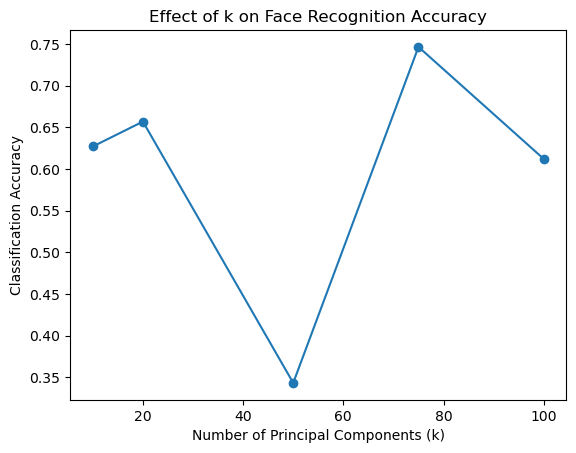

In [26]:
import matplotlib.pyplot as plt

k_values = [10, 20, 50, 75, 100]
accuracies = []

for k in k_values:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    mlp.fit(X_train_pca, y_train)  # Using 'mlp' instead of 'model'
    y_pred = mlp.predict(X_test_pca)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Classification Accuracy")
plt.title("Effect of k on Face Recognition Accuracy")
plt.show()


In [27]:
# Step 1: Compute the mean face from the original training set (before PCA transformation)
mean_face = np.mean(X_train, axis=0)  # Compute the mean face across all training images

# Step 2: Apply PCA transformation to the mean face (project it to PCA space)
# We need to project the mean face onto the PCA components. 
mean_face_pca = pca.transform([mean_face])  # Project mean face into the PCA space

# Step 3: Simulate an imposter face (random values in PCA space)
imposter_face = np.random.randn(pca.n_components_)  # Simulating an imposter face in PCA space

# Step 4: Zero the mean face (subtract the mean face in the PCA space)
imposter_face_zeroed = imposter_face - mean_face_pca.flatten()  # Ensure both are in the PCA space

# Step 5: Use the trained MLP model to predict the label of the imposter face
predicted_label = mlp.predict([imposter_face_zeroed])  # MLP classifier predicting the class of the imposter face

# Step 6: Output the result
print("Predicted Label for Imposter Face:", predicted_label)


Predicted Label for Imposter Face: [1]


In [28]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate centroids for each class
class_centroids = []
for i in range(len(np.unique(y_train))):
    class_centroids.append(np.mean(X_train_pca[y_train == i], axis=0))

class_centroids = np.array(class_centroids)

# Calculate the Euclidean distance between the imposter face and class centroids
imposter_distances = euclidean_distances([imposter_face], class_centroids)

# If the distance is above a threshold, classify it as an imposter
threshold = 5  # Example threshold
if np.min(imposter_distances) > threshold:
    print("Imposter detected!")
else:
    print("Imposter is a known class.")


Imposter detected!


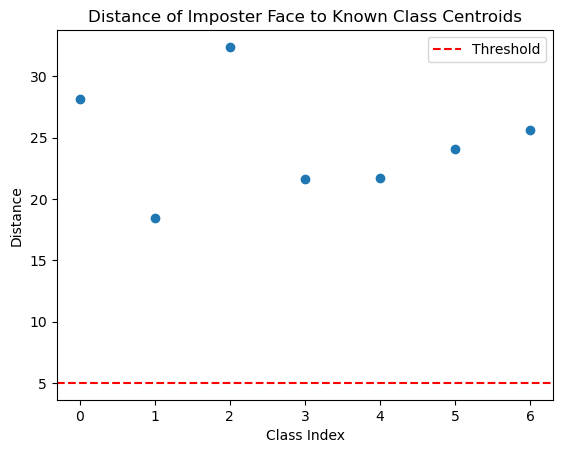

In [29]:
import matplotlib.pyplot as plt

plt.scatter(range(len(imposter_distances[0])), imposter_distances[0])
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.title("Distance of Imposter Face to Known Class Centroids")
plt.xlabel("Class Index")
plt.ylabel("Distance")
plt.legend()
plt.show()


Classification Report:
               precision    recall  f1-score   support

      Akshay       0.75      0.43      0.55         7
        Alia       0.60      0.60      0.60        10
     Amitabh       0.71      1.00      0.83        10
     Deepika       0.50      0.40      0.44        10
       Disha       0.58      0.70      0.64        10
      Farhan       0.60      0.60      0.60        10
      Ileana       0.56      0.50      0.53        10

    accuracy                           0.61        67
   macro avg       0.61      0.60      0.60        67
weighted avg       0.61      0.61      0.60        67



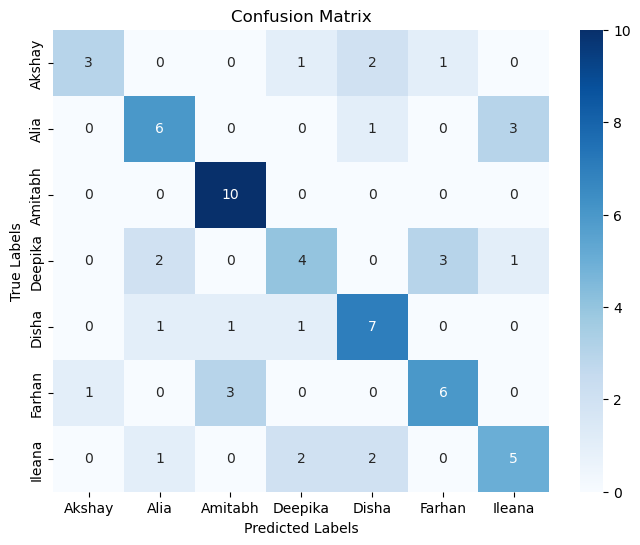

Accuracy: 0.61
Imposter Detection Metrics:
Precision: 0.61
Recall: 0.60
F1-Score: 0.60


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = mlp.predict(X_test_pca)

# Classification report (includes precision, recall, F1-score)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, F1-Score for the "Imposter" class (if available)
# Assuming the imposter faces are mapped to a specific class, like 0 or 1
# You may need to adjust the class index based on your actual data (e.g., class 0, imposter might be class 1, etc.)

imposter_class_index = 0  # Replace with the actual class index for the imposter in your data
from sklearn.metrics import precision_recall_fscore_support

# Use 'micro', 'macro', or 'weighted' for multiclass averaging
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"Imposter Detection Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


In [31]:
# Install necessary library
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Balance dataset with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=10, cv=3, verbose=2, random_state=42
)
random_search.fit(X_train_res, y_train_res)
best_rf_params = random_search.best_params_

# Define classifiers with tuned hyperparameters
clf_rf = RandomForestClassifier(**best_rf_params, class_weight='balanced')
clf_svm = SVC(class_weight='balanced')
clf_xgb = xgb.XGBClassifier(scale_pos_weight=10)

# Ensemble Model
ensemble_model = VotingClassifier(
    estimators=[('rf', clf_rf), ('svm', clf_svm), ('xgb', clf_xgb)],
    voting='hard'
)
ensemble_model.fit(X_train_res, y_train_res)

# Model Evaluation
y_pred = ensemble_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_s

C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.7164179104477612
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.47      0.70      0.56        10
           2       0.91      1.00      0.95        10
           3       0.78      0.70      0.74        10
           4       0.56      0.50      0.53        10
           5       0.90      0.90      0.90        10
           6       0.75      0.60      0.67        10

    accuracy                           0.72        67
   macro avg       0.74      0.71      0.72        67
weighted avg       0.73      0.72      0.72        67

Confusion Matrix: 
 [[ 4  0  0  0  2  1  0]
 [ 0  7  0  1  0  0  2]
 [ 0  0 10  0  0  0  0]
 [ 0  2  0  7  1  0  0]
 [ 1  2  1  1  5  0  0]
 [ 0  1  0  0  0  9  0]
 [ 0  3  0  0  1  0  6]]
